In [73]:
# Import required libraries.
import numpy as np

import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image
import imghdr

from sklearn.metrics import classification_report
# from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomContrast
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout

import matplotlib.pyplot as plt

In [44]:
TRANING_DATASET_PATH = 'C:\\PRZEMEK\\Data_Analysis\\projects\\Python\\F1\\BolidVision\\data\\raw\\red_bull_mercedes_jpg'
TEST_DATASET_PATH = 'C:\\PRZEMEK\\Data_Analysis\\projects\\Python\\F1\\BolidVision\\data\\test_dataset'

# Data preparation

In [45]:
batch_size=32
image_size=(224, 224)
seed=42

# Create training dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TRANING_DATASET_PATH,
    label_mode='binary',  
    shuffle=True,
    batch_size=batch_size,
    image_size=image_size,
    validation_split=0.2,  
    subset="training",
    seed=seed
)

# Create validation dataset
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TRANING_DATASET_PATH,
    label_mode='binary',
    shuffle=True,
    batch_size=batch_size,
    image_size=image_size,
    validation_split=0.2,
    subset="validation",
    seed=seed
)

# Create test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DATASET_PATH,
    label_mode='binary',
    shuffle=False,
    batch_size=batch_size,
    image_size=image_size
)

class_names = train_dataset.class_names  # Get the class names from the training dataset

print("Labels:", class_names)

Found 104 files belonging to 2 classes.
Using 84 files for training.
Found 104 files belonging to 2 classes.
Using 20 files for validation.
Found 22 files belonging to 2 classes.
Labels: ['mercedes', 'red_bull']


In [46]:
create_image_datasets(IMG_PATH, TEST_DATASET)

Found 104 files belonging to 2 classes.
Using 84 files for training.
Found 104 files belonging to 2 classes.
Using 20 files for validation.
Found 22 files belonging to 2 classes.
Labels: ['mercedes', 'red_bull']


(<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>)

In [47]:
def display_images_from_dataset(dataset, num_images=6):
    """
    Displays a specified number of random images from a given dataset along with their class names.

    Args:
        dataset (tf.data.Dataset): The dataset to display images from.
        num_images (int, optional): The number of random images to display. Default is 6.
    """
    # Get class names from the dataset
    class_names = dataset.class_names
    
    # Get the first batch of data from the dataset
    for images, labels in dataset.take(1):
        # Choose num_images random indices of images
        num_total_images = images.shape[0]
        random_indices = np.random.choice(num_total_images, num_images, replace=False)

        # Select the images and labels corresponding to the random indices
        selected_images = tf.gather(images, random_indices)
        selected_labels = tf.gather(labels, random_indices)

        # Display the selected images with their class names
        plt.figure(figsize=(12, 8))
        for i in range(num_images):
            plt.subplot(2, 3, i + 1)
            plt.imshow(selected_images[i].numpy().astype("uint8"))
            label_index = int(selected_labels[i].numpy())
            plt.title(f"Class: {class_names[label_index]}")
            plt.axis("off")

        plt.show()

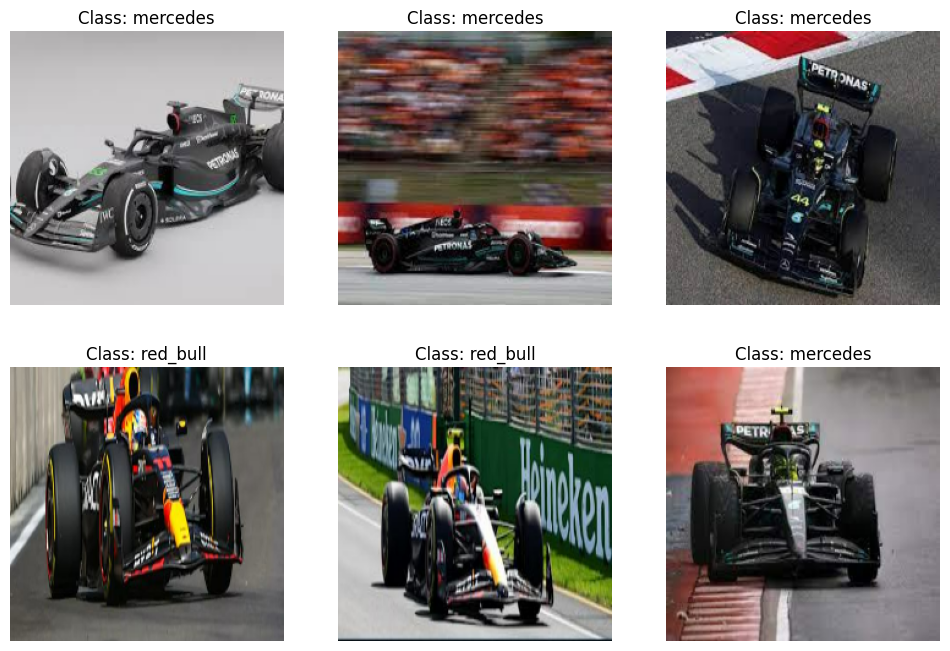

In [48]:
display_images_from_dataset(train_dataset)

# Model

In [32]:
# Base VGG model
base_vgg_model = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_vgg_model.trainable = False

In [36]:
# Data augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.4), 
    tf.keras.layers.RandomContrast(0.4),
    tf.keras.layers.RandomBrightness(0.4)  
])

In [38]:
# Definition of a CNN model with data augmentation based on VGG architecture
model = Sequential(
    [
        data_augmentation,
        base_vgg_model,
        Conv2D(512, (3, 3), activation='relu'),
        MaxPool2D(2, 2),
        Flatten(),
        Dense(512, activation='relu', kernel_initializer='he_normal'),
        Dropout(0.3),
        Dense(512, activation='relu', kernel_initializer='he_normal'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ]
)

In [39]:
# Compile the model using the Adam optimizer, binary_crossentropy loss function, and accuracy metric.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [41]:
# Importing Keras callbacks for early stopping and learning rate reduction
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define early stopping with patience of 4 epochs
earlystop = EarlyStopping(patience=4)

# Define learning rate reduction callback to monitor validation loss, reduce by a factor of 0.2, and set a minimum learning rate
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=4, 
                                            verbose=2, 
                                            factor=0.2, 
                                            min_lr=0.0001)

# Combine both callbacks into a list
callbacks = [earlystop, learning_rate_reduction]

In [50]:
# Train the model using the training dataset, validate on the validation dataset,
# run for 20 epochs, display training progress, and apply defined callbacks.
history = model.fit(train_dataset, validation_data=validation_dataset,
                        epochs=20, verbose = 1, callbacks=callbacks)

Epoch 1/20
3/3 [==============================] - 19s 6s/step - loss: 45.9470 - accuracy: 0.4405 - val_loss: 49.3789 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
3/3 [==============================] - 16s 6s/step - loss: 29.7346 - accuracy: 0.5238 - val_loss: 6.9082 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
3/3 [==============================] - 16s 5s/step - loss: 7.7520 - accuracy: 0.4643 - val_loss: 4.9133 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/20
3/3 [==============================] - 16s 6s/step - loss: 4.3823 - accuracy: 0.5476 - val_loss: 4.5708 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/20
3/3 [==============================] - 16s 6s/step - loss: 3.4315 - accuracy: 0.5476 - val_loss: 3.8942 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/20
3/3 [==============================] - 16s 5s/step - loss: 2.7344 - accuracy: 0.5238 - val_loss: 1.3131 - val_accuracy: 0.5500 - lr: 0.0010
Epoch 7/20
3/3 [==============================] - 16s 5s/step - loss: 1.5360 - accuracy: 0.

In [53]:
def plot_history(history):
    """
    Plot training and validation loss and accuracy curves.

    Args:
        history (keras.callbacks.History): The training history obtained from a Keras model.fit() call.

    Returns:
        None
    """

    # Plot the Loss Curves
    plt.figure(figsize=[6, 4])
    plt.plot(history.history['loss'], 'o--', linewidth=3.0, label='Training loss')
    plt.plot(history.history['val_loss'], 'p--', linewidth=3.0, label='Validation Loss')
    plt.legend(fontsize=18)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.title('Loss Curves', fontsize=16)

    # Plot the Accuracy Curves
    plt.figure(figsize=[8, 6])
    plt.plot(history.history['accuracy'], 'o--', linewidth=3.0, label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], 'p--', linewidth=3.0, label='Validation Accuracy')
    plt.legend(fontsize=18)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.title('Accuracy Curves', fontsize=16)

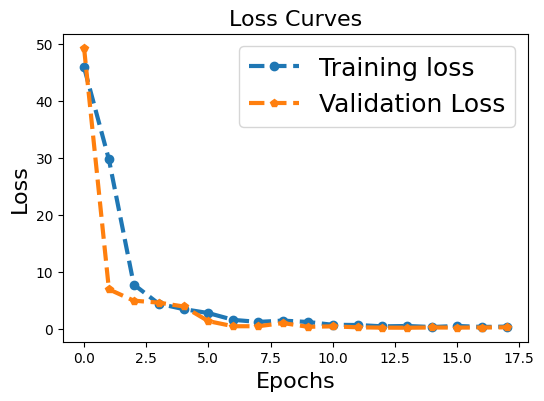

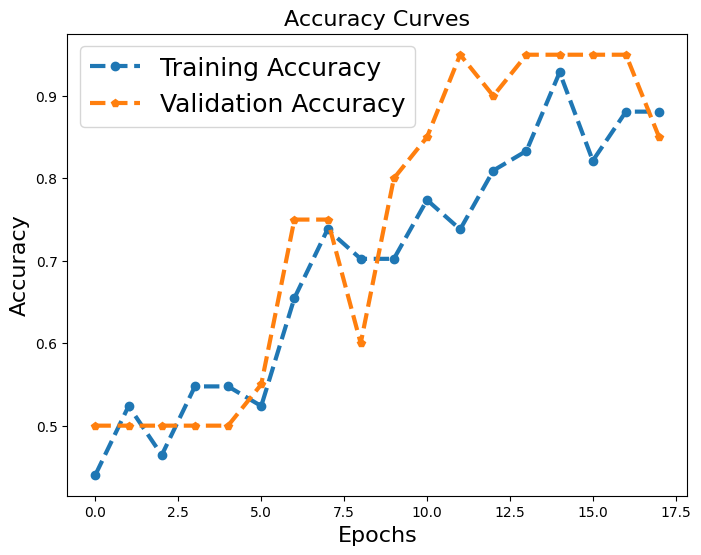

In [54]:
plot_history(history)

# Classification report

In [57]:
def get_predictions(model, dataset):
    predictions = []
    true_labels = []

    for x, y in dataset:
        y_pred = model.predict(x)
        predictions.extend(np.argmax(y_pred, axis=1))
        true_labels.extend(y)
    return true_labels, predictions

In [58]:
true_labels, predictions = get_predictions(model, test_dataset)

1/1 [==============================] - 3s 3s/step


In [59]:
report = classification_report(true_labels, predictions)
print(report)

              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67        11
         1.0       0.00      0.00      0.00        11

    accuracy                           0.50        22
   macro avg       0.25      0.50      0.33        22
weighted avg       0.25      0.50      0.33        22



C:\Users\Przemek\f1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Przemek\f1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Przemek\f1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [70]:
def get_predictions(model, dataset):
    """
    Get true labels and predicted labels for a given model and dataset.

    Args:
        model (tf.keras.Model): The trained model for making predictions.
        dataset (tf.data.Dataset): The dataset containing test samples and labels.

    Returns:
        tuple: A tuple containing two lists - true_labels and predicted_labels.
               true_labels: List of true labels from the dataset.
               predicted_labels: List of predicted labels generated by the model.
    """
    # Initialize empty lists for true labels and predicted labels
    true_labels = []
    predicted_labels = []

    # Iterate through the test dataset to obtain true labels and predictions
    for batch in dataset:
        images, labels = batch
        predictions = model.predict(images)
        
        # Add true labels to the list
        true_labels.extend(labels.numpy())
        
        # Add predicted labels to the list
        predicted_labels.extend(np.round(predictions).flatten())

    return true_labels, predicted_labels

In [71]:
true_labels, predictions = get_predictions(model, test_dataset)

1/1 [==============================] - 3s 3s/step


In [72]:
report = classification_report(true_labels, predictions)
print(report)

              precision    recall  f1-score   support

         0.0       1.00      0.73      0.84        11
         1.0       0.79      1.00      0.88        11

    accuracy                           0.86        22
   macro avg       0.89      0.86      0.86        22
weighted avg       0.89      0.86      0.86        22



In [77]:
def plot_confusion_matrix(true_labels, predicted_labels, class_labels=None):
    """
    Plot a confusion matrix using true labels and predicted labels.

    Args:
        true_labels (list): List of true labels.
        predicted_labels (list): List of predicted labels.
        class_labels (list, optional): List of class labels. Default is None.

    Returns:
        None
    """
    # Calculate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Create a ConfusionMatrixDisplay object
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

    # Plot the confusion matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

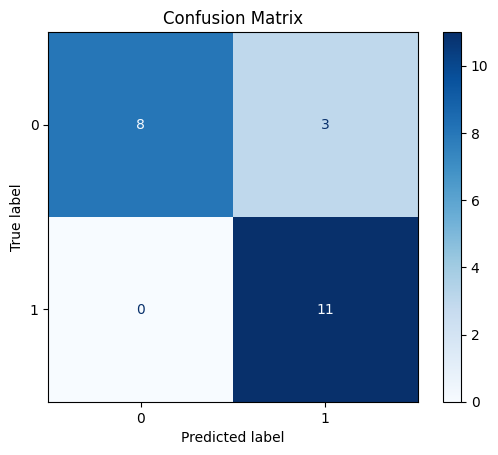

In [81]:
plot_confusion_matrix(true_labels, predictions)

# Grad-CAM class activation visualization